# Mathematics behind the radial time graphs

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

In [3]:
cmap_cones = 'viridis_r'

---

(this is copied directly from the geography notebook)

# Define time grids.

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

+ IVT centre: (0, 0)
+ IVT/MT centre: (0, $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$)

Change these parameters:

In [4]:
time_travel_ivt_to_mt  = 50

# Only calculate travel times up to this x and y displacement:
time_travel_max       = 80

# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [5]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.copy(x_times) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking the rows (xx) 
    # and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Travel time directly to the IVT centre:

In [6]:
grid_time_travel_directly_to_ivt = make_time_grid(grid_xy_max, grid_step)

Travel time directly to the MT centre:

In [7]:
grid_time_travel_directly_to_mt = (
    make_time_grid(grid_xy_max, grid_step, 
                   y_offset=-time_travel_ivt_to_mt) )

Difference in travel time:

In [8]:
grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

## Plot the grids

In [9]:
extent = [-grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5, 
          -grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5] 

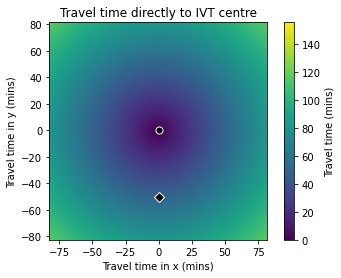

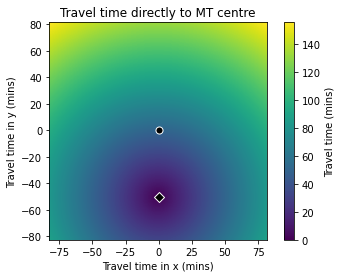

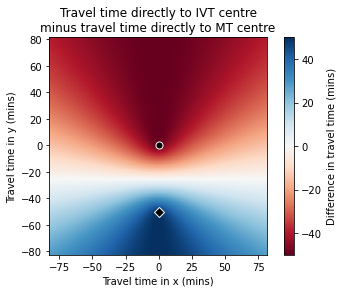

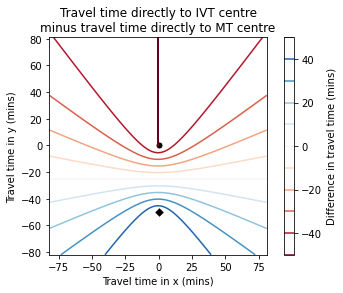

In [10]:
vmin = 0
vmax = np.max([grid_time_travel_directly_to_ivt,
               grid_time_travel_directly_to_mt])

for i in range(4):
    if i==0:
        # Travel directly to IVT centre
        plt.imshow(grid_time_travel_directly_to_ivt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to IVT centre')
        
    elif i==1:
        # Travel directly to IVT/MT centre
        plt.imshow(grid_time_travel_directly_to_mt, origin='lower', 
                   extent=extent, vmin=vmin, vmax=vmax)
        plt.colorbar(label='Travel time (mins)')
        plt.title('Travel time directly to MT centre')
        
    elif i==2:
        # Difference grid 
        plt.imshow(grid_time_travel_directly_diff, origin='lower', 
                   extent=extent, cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
        
    elif i==3:
        # Difference contours
        plt.contour(grid_time_travel_directly_diff, origin='lower', 
                    extent=extent,
                    levels=np.arange(-50,60,10), cmap='RdBu')
        plt.colorbar(label='Difference in travel time (mins)')
        plt.title('Travel time directly to IVT centre'+'\n'+
                  'minus travel time directly to MT centre')
                
    # Mark the treatment centre locations:
    plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
    plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
                color='k', edgecolor='w', s=50)

    plt.xlabel('Travel time in x (mins)')
    plt.ylabel('Travel time in y (mins)')
    
    plt.gca().set_aspect('equal')
    plt.show()

There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

---

(new stuff!)

# Reinterpreting the time maps

To make it easier to see where the curves come from, we can imagine that the grids are already plotted in three dimensions. The x and y are the same, just travel time from the centre. In the previous chart we've drawn the distance from the centre by colouring the grid, but we could instead define a z-axis and plot farther-away values as higher up the axis.

In [127]:
levels = np.linspace(0.0, time_travel_max, 17)

In [128]:
colours_levels = plt.get_cmap(cmap_cones)(np.linspace(0,1,len(levels)))[1:]

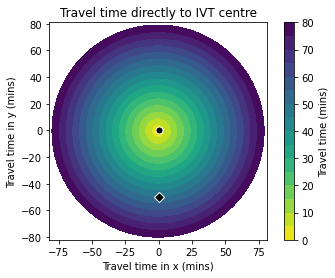

In [129]:
# Travel directly to IVT centre
plt.contourf(grid_time_travel_directly_to_ivt, origin='lower', 
             extent=extent, vmin=0, vmax=time_travel_max,
             levels = levels,
            cmap=cmap_cones)
plt.colorbar(label='Travel time (mins)')
plt.title('Travel time directly to IVT centre')

# Mark the treatment centre locations:
plt.scatter(0,0, marker='o', color='k', edgecolor='w', s=50)
plt.scatter(0,-time_travel_ivt_to_mt, marker='D', 
            color='k', edgecolor='w', s=50)

plt.xlabel('Travel time in x (mins)')
plt.ylabel('Travel time in y (mins)')

plt.gca().set_aspect('equal')
plt.show()

Define (x,y,z) coordinates for each colour level in the cone.

In [130]:
n_coords    = 45
cone_angles = np.linspace(0.0, 2.0*np.pi, n_coords)

In [131]:
def make_cone_coords(levels, cone_angles_all):
    cone_coords = [] 
    for l, level in enumerate(levels):
        if cone_angles_all.ndim > 1:
            cone_angles = cone_angles_all[l]
        else:
            cone_angles = cone_angles_all
            
        x = level*np.cos(cone_angles)
        y = level*np.sin(cone_angles)
        z = np.full(x.shape, level)
        cone_coords.append([x,y,z])

    # Creating an object array messes up the trisurf later
    # cone_coords = np.array(cone_coords, dtype=object)
    return cone_coords

In [132]:
cone_coords = make_cone_coords(levels, cone_angles)

Define a function for plotting:

In [133]:
def draw_cone_3d(ax, levels, cone_coords, colours_levels):

    for i in range(1,len(levels)):
    #     ax.plot(cone_coords[i][0], cone_coords[i][1], cone_coords[i][2], color=colours_levels[i-1])

        # Weirdly, plotting trisurf directly fills in the bottom of the cone.
        # It plots extra unwanted triangles to fill in a circle at z=zmin.
        # To prevent this, draw each triangle individually:
        for j in range(len(cone_coords[i][0])-1):
            ax.plot_trisurf(
                np.stack([cone_coords[i][0][j:j+2], cone_coords[i-1][0][j:j+2]],axis=1).ravel(), 
                np.stack([cone_coords[i][1][j:j+2], cone_coords[i-1][1][j:j+2]],axis=1).ravel(),  
                np.stack([cone_coords[i][2][j:j+2], cone_coords[i-1][2][j:j+2]],axis=1).ravel(), 
                color=colours_levels[i-1], shade=False#, alpha=0.6#, shade=False
            )

    
    ax.set_xlabel('Travel time in x (mins)') 
    ax.set_ylabel('Travel time in y (mins)') 
    ax.set_zlabel('Travel time (mins)') 
    
    ax.set_zlim(0, time_travel_max)
    return ax

Plot some cones:

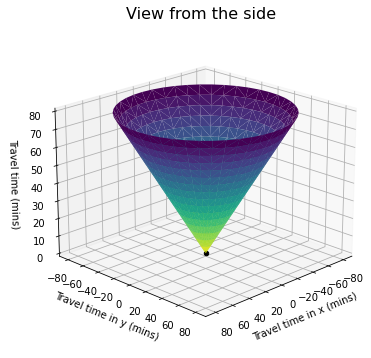

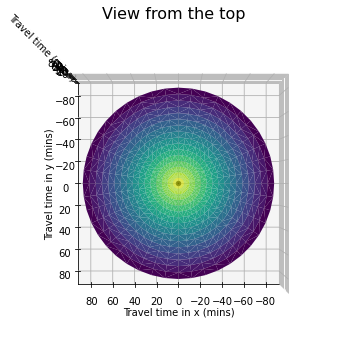

In [135]:
viewing_angles_list = [[45,20], [90,90]]
titles_list = ['View from the side', 'View from the top']

for v,(azim, elev) in enumerate(viewing_angles_list):
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(projection='3d', azim=azim, elev=elev)
    draw_cone_3d(ax, levels, cone_coords, colours_levels)
    # Mark the origin: 
    ax.scatter(0,0,0, color='k', marker='o')
    ax.set_title(titles_list[v], fontsize=16)
    plt.show()

n.b. the axis limits don't appear to exactly match the 2D imshow plot. This is just because of matplotlib's 3D projection - the z-axis sticks out of the page a bit instead of being flattened. 

---

# Slicing through the cone

To find the variation in (time distance from the origin) for a slice along the y-axis (fixed x), can look at it as slice through the cone. 

Might need this for the rectangle slice:

In [136]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle

In [137]:
xcut_list = [0, 30, 60]

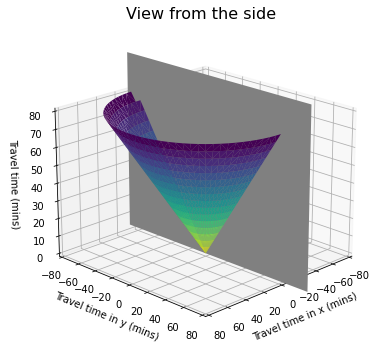

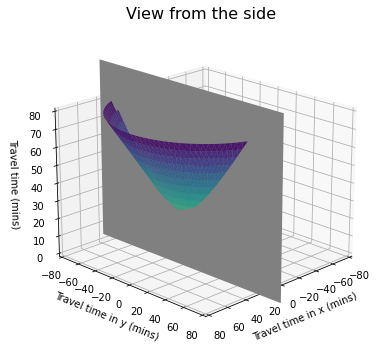

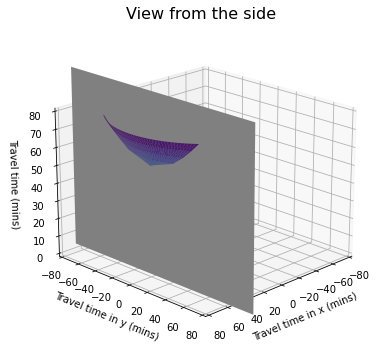

In [138]:
for xcut in xcut_list:
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(projection='3d', azim=45, elev=20)
    
    cone_angles_cuts_all = []
    plot_levels = []
    plot_colours = []
    for l, level in enumerate(levels):
        if level>=xcut:
            plot_levels.append(level)
            if level!=0.0:
                plot_colours.append(colours_levels[l-1])
                angle_max = np.arccos(xcut/level)
                cone_angles = np.linspace(-angle_max, angle_max, n_coords)
            else:
                cone_angles = np.full(n_coords, 0.0)
            cone_angles_cuts_all.append(cone_angles)
    cone_angles_cuts_all = np.array(cone_angles_cuts_all, dtype=float)
    
    
        
    cone_coords_cuts = make_cone_coords(plot_levels, cone_angles_cuts_all)
    
    draw_cone_3d(ax, plot_levels, cone_coords_cuts, plot_colours)
        
    # Draw a slicing rectangle: 
    p = Rectangle((-90, 0), 200, 100, facecolor='Grey')
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=xcut, zdir='x')

    ax.set_xlim(-time_travel_max, time_travel_max)
    ax.set_ylim(-time_travel_max, time_travel_max)
    ax.set_title('View from the side', fontsize=16)
    plt.show()